In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import datetime
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import keras_tuner as kt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:
with open(r'.\News_Dataset_Splits\X_train.pkl', 'rb') as f:
    X_train = pickle.load(f)

with open(r'.\News_Dataset_Splits\X_val.pkl', 'rb') as f:
    X_val = pickle.load(f)

with open(r'.\News_Dataset_Splits\X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)

with open(r'.\News_Dataset_Splits\y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)

with open(r'.\News_Dataset_Splits\y_val.pkl', 'rb') as f:
    y_val = pickle.load(f)

with open(r'.\News_Dataset_Splits\y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

encoder = LabelEncoder()
encoder.fit(np.unique(y_train))
train_labels = encoder.transform(y_train)
val_labels = encoder.transform(y_val)
test_labels = encoder.transform(y_test)
num_classes = len(encoder.classes_)
train_one_hot = keras.utils.to_categorical(train_labels, num_classes=num_classes)
val_one_hot = keras.utils.to_categorical(val_labels, num_classes=num_classes)
test_one_hot = keras.utils.to_categorical(test_labels, num_classes=num_classes)

with open(r'.\embeddingMatrix_News.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)

num_tokens = len(embedding_matrix) # total vocabulary +1 or length of embedding matrix
embedding_dim = 300 # dimension of the vector of a single word
MAX_NEWS_LEN = 500 # maximum words in a review

In [3]:
embedding_layer = keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    input_length=MAX_NEWS_LEN,
    trainable=True)

model = keras.Sequential()
model.add(embedding_layer)

activation = 'softplus'
kernel_initializer = 'random_uniform'

model.add(layers.Conv1D(filters=128, kernel_size=5, activation=activation, kernel_initializer=kernel_initializer, padding='same'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.MaxPooling1D(pool_size=2))

model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
NUM_EPOCHS = 2
BATCH_SIZE = 128
history = model.fit(X_train, train_one_hot, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, val_one_hot))

Epoch 1/2
1488/1488 [==============================] - 51s 32ms/step - loss: 0.8851 - accuracy: 0.7481 - val_loss: 0.6324 - val_accuracy: 0.8354
Epoch 2/2
1488/1488 [==============================] - 47s 32ms/step - loss: 0.4476 - accuracy: 0.8804 - val_loss: 0.5996 - val_accuracy: 0.8362


In [5]:
score = model.evaluate(X_val, val_one_hot, verbose=1)
print("Validation loss: ", score[0])
print("Validation accuracy: ", score[1])

1488/1488 [==============================] - 3s 2ms/step - loss: 0.5996 - accuracy: 0.8362
Validation loss:  0.5996134877204895
Validation accuracy:  0.8362184762954712


In [6]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_actuals = np.argmax(test_one_hot, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_actuals, y_prediction , normalize='pred')
print(result)

1313/1313 [==============================] - 2s 1ms/step
[[0.8245977  0.013396   0.02168843 0.01060158 0.01484674 0.0173494
  0.02122803 0.00523697 0.01705209 0.03369463]
 [0.01586207 0.8333725  0.02028918 0.01109467 0.01748084 0.01012048
  0.05227117 0.02985075 0.01261388 0.00636192]
 [0.02574713 0.01457109 0.7889459  0.01282051 0.04861111 0.01493976
  0.03538005 0.00445143 0.00934361 0.02097078]
 [0.01701149 0.01245593 0.02262127 0.83974359 0.05627395 0.01710843
  0.01574983 0.00209479 0.01378183 0.01248822]
 [0.02045977 0.01104583 0.04897388 0.06977318 0.77274904 0.03855422
  0.02876056 0.00366588 0.01751927 0.02309142]
 [0.01678161 0.00822562 0.02751866 0.01306706 0.03783525 0.86915663
  0.00798904 0.00288034 0.01985517 0.01154571]
 [0.01609195 0.03666275 0.02518657 0.01060158 0.01891762 0.00819277
  0.7849806  0.0102121  0.01494978 0.00918944]
 [0.00712644 0.04911868 0.01166045 0.0071499  0.00670498 0.00506024
  0.0257932  0.93820372 0.01074515 0.00730443]
 [0.02091954 0.01034078 

In [7]:
accuracy_score = metrics.accuracy_score(y_prediction, y_actuals)

print('CNN accuracy is',str('{:04.2f}'.format(accuracy_score*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_actuals, y_prediction)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_actuals, y_prediction))

CNN accuracy is 83.56%
------------------------------------------------
Confusion Matrix:
      0     1     2     3     4     5     6     7     8     9
0  3587    57    93    43    62    72    93    20    73   143
1    69  3546    87    45    73    42   229   114    54    27
2   112    62  3383    52   203    62   155    17    40    89
3    74    53    97  3406   235    71    69     8    59    53
4    89    47   210   283  3227   160   126    14    75    98
5    73    35   118    53   158  3607    35    11    85    49
6    70   156   108    43    79    34  3439    39    64    39
7    31   209    50    29    28    21   113  3583    46    31
8    91    44    48    53    62    46    79     7  3691    87
9   154    46    94    49    49    35    43     6    94  3628
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      4243
           1       0.83      0.83      0.83    

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

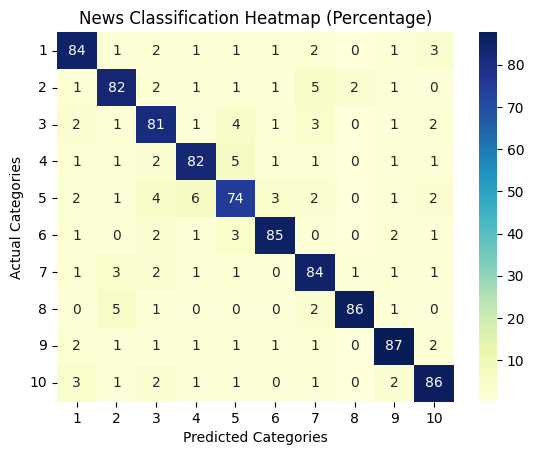

In [9]:
# Create a confusion matrix
confusion_matrix = np.zeros((num_classes, num_classes))
for i in range(len(y_prediction)):
    confusion_matrix[y_actuals[i], y_prediction[i]] += 1

# Normalize the confusion matrix to show percentages
confusion_matrix = 100 * confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)

lables = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Create a heatmap with annotation
annot_matrix = np.around(confusion_matrix, 1).astype(int)  # Round percentages to 1 decimal place
ax = sns.heatmap(confusion_matrix, annot=annot_matrix, fmt='d', cmap="YlGnBu", xticklabels=lables, yticklabels=lables)

# Set the title and axis labels
plt.title("News Classification Heatmap (Percentage)")
plt.xlabel("Predicted Categories")
plt.ylabel("Actual Categories")

# Rotate the x-axis labels for better visibility
plt.yticks(rotation=0)

# Display the heatmap
plt.show()

In [10]:
from tensorflow.keras.models import load_model
import os

# Save the model
model_save_path = 'SavedModels/CNN_BestModel.h5'
model.save(model_save_path)

In [11]:
# Load the model
loaded_model = load_model(model_save_path)
score2 = loaded_model.evaluate(X_val, val_one_hot, verbose=1)
print("Validation loss: ", score2[0])
print("Validation accuracy: ", score2[1])

1488/1488 [==============================] - 3s 2ms/step - loss: 0.5996 - accuracy: 0.8362
Validation loss:  0.5996134877204895
Validation accuracy:  0.8362184762954712
